# Week 12 (Wednesday), AST 8581 / PHYS 8581 / CSCI 8581: Big Data in Astrophysics

### Michael Coughlin <cough052@umn.edu>, Jie Ding <dingj@umn.edu>

With contributions totally ripped off from With contributions totally ripped off from Dima Duev (Weights and Biases), Matthew Graham (CIT), Mauro San Martín (U La Serena), Ian Dennis Miller (U Toronto), Allen Downey (Olin), Michael Steinbach (UMN), Nico Adams (UMN), and Lee Bergstrand (Amplytica)



# Where do we stand?

Foundations of Data and Probability -> Statistical frameworks (Frequentist vs Bayesian) -> Estimating underlying distributions -> Analysis of Time series (periodicity) -> Analysis of Time series (variability) -> Analysis of Time series (stochastic processes) -> Gaussian Processes -> Decision Trees / Regression -> Dimensionality Reduction -> Principle Component Analysis -> Clustering -> Density Estimation / Anomaly Detection -> Supervised Learning -> Deep Learning -> Introduction to Databases - SQL -> Introduction to Databases - NoSQL

# NoSQL databases: MongoDB

##  NoSQL (not only SQL / non SQL) databases

- What drove the development of NoSQL? - Pros and cons of traditional SQL systems
- What are the different flavors of NoSQL?
- Wide column-based
- Key-value
- Document-based
- Graph-based
 

##  Pros and cons of traditional RDBMS

### Positives
- Have been around for quite a while
- SQL: mature and powerful
- Transactions + ACID-compliance
built-in
- Data normalization + joins
- Schema: good when data can be
represented in appropriate way
- Many open-source solutions

### Negatives
- Vertical scale-out | scaling issues 
- Joins + transactions across
multiple dbs quickly become costly for complicated objects and big data -> performance and availability are affected
- Object-relational impedance mismatch
- Schema: bad for unstructured/evolving data

## NoSQL: motivation and promise

The design and development of NoSQL databases has been largely driven by the RDBMS cons from the previous slide.
- Deliver performance for big, potentially unstructured or evolving data that may
come in in real time
- Simple design
- Horizontal scaling
- NoSQL ~= not only SQL, i.e. some systems support SQL-like query languages
 

##  NoSQL: fulfilling the promise

Always comes with a cost!
- Most such systems lack ACID transactions and offer BASE (Basic Availability,
Soft state and Eventual consistency) instead
- See ACID vs BASE
- Some systems exhibit potential lost writes and other forms of data loss
- A notable exception is MongoDB
- No schema means data integrity might become an issue
- Some systems do allow defining schemas and perform validation/enforcement (e.g.
MongoDB)
- Many query languages vs single SQL (albeit with different flavors)
 

## NoSQL: relational data

In practice, you almost always still need to deal with relational data! There are three main techniques to do that:
- Nesting/embedding data
- Store all data needed for a specific task in one place (e.g. in a single document)
- Linking + Multiple queries
- Store a foreign key and fetch data in multiple queries. Since single queries in NoSQL are often
more performant than in SQL, may be ok
- Caching and replication
- Instead of storing a foreign key, store the actual values
Data schema modelling must be done very differently from RDBMS. A simple translation would often not work.
 

## Main types of NoSQL databases

- Key-value store
  - Uses maps/dictionaries/associated lists/hash tables with corresponding operation complexities
  - Examples: Redis, ArangoDB, ZooKeeper, Couchbase, Cassandra, Amazon DynamoDB
- Wide column store
  - Essentially, a two-dimensional semi-structured key-value store
  - Examples: Cassandra, HBase
- Document store
  - Semi-structured; data are encapsulated in some standard form (XML, JSON, BSON) in "documents" with unique keys/identifiers
  - Often uses B-trees with corresponding operation complexities
  - Examples: Couchbase, MongoDB, Amazon DynamoDB
- Graph store
  - Uses graphs to represent data + relationship between them (the latter can be queried, too)
  - Examples: Neo4J, ArangoDB
 

# Performance

![performance table](figures/performance.png)

## In this exercise, we will work with one of the most popular (document-based) NoSQL databases - [`MongoDB`](https://mongodb.com). 
Concretely, we will:

- Deploy a `MongoDB` database
- Fetch some public transient alerts from the [Zwicky Transient Facility](https://ztf.caltech.edu), ingest them into the database, and create indices in the database for faster queries
- Query the database using python
    - Inspect the contents of an alert packet
    - Construct and plot a light curve
    - Plot the cutout images from an alert packet

### Setup MongoDB

In [1]:
# Install postgresql server
!echo "deb [ arch=amd64,arm64 ] https://repo.mongodb.org/apt/ubuntu bionic/mongodb-org/4.4 multiverse" | sudo tee /etc/apt/sources.list.d/mongodb-org-4.4.list
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install mongodb
!sudo systemctl start mongod

deb [ arch=amd64,arm64 ] https://repo.mongodb.org/apt/ubuntu bionic/mongodb-org/4.4 multiverse
W: GPG error: https://repo.mongodb.org/apt/ubuntu bionic/mongodb-org/4.4 Release: The following signatures couldn't be verified because the public key is not available: NO_PUBKEY 656408E390CFB1F5
E: The repository 'https://repo.mongodb.org/apt/ubuntu bionic/mongodb-org/4.4 Release' is not signed.
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 7.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libpcap0.8:amd64.
(Reading database ... 128293 files and directories currently installed.)
Preparing to unpack .../0-l

### MongoDB

Create a persistent `docker` volume (so that your data are not wiped out when you remove the container):

In [2]:
!nohup mongod --port 27017 --dbpath /var/lib/mongodb & 

nohup: appending output to 'nohup.out'


### python libraries:

Make sure to install the following python libraries:

In [3]:
%%capture
!pip install pymongo requests matplotlib numpy pandas astropy tqdm

## Why use MongoDB in astronomy?

[`MongoDB`](https://www.mongodb.com/what-is-mongodb), the [most popular and feature-rich document-based NoSQL database to date](https://db-engines.com/en/ranking), naturally fits a number of use cases in astronomy, especially in modern time-domain astronomy.

- Uses <a href="https://www.mongodb.com/json-and-bson" target="_blank">BSON</a> (serialized binary python-dictionary-like structures) documents to store the data in collections (a rough analog of a table in the RDBMS world). 
    - Natural to store alerts from sky surves such as ZTF or the upcoming [LSST](https://www.lsst.org/). For example, the widely used [AVRO](https://avro.apache.org/) format directly translates into BSON. 
    - Astronomical object light curves - 1 read per source to extract all data points for a source as opposed to multiple joins if RDBMS were used (one row per data point).
- Giant [B-tree](https://en.wikipedia.org/wiki/B-tree): O(log(N)) guaranteed for search, insert, and delete operations, where N is the number of documents in a collection
    - blazing fast with (multiple) clever (compound) indexes and covered queries
- No schema by default but can be enforced if need be
    - No downtime when the incoming data schema changes, e.g. the alert packet schema evolves over time
- Built-in [GeoJSON support with 2D indices on the sphere](https://docs.mongodb.com/manual/reference/geojson/)
    - Positional queries (e.g. cone-searches) are supported out of the box with excellent performance
- [MongoDB Query Language (MQL)](https://docs.mongodb.com/manual/tutorial/query-documents/): cone and general searches, aggregation pipelines
    - Supports LEFT-OUTER-JOIN-like operations
- Horizontal scale-out
    - Sharding supported out-of-the box
- ACID-compliant transactions:
    - As of version `4.2` supports transactions and is ACID-compliant even across sharded clusters
    
For a very quick intro into MongoDB, watch [MongoDB in 5 Minutes with Eliot Horowitz](https://www.youtube.com/watch?v=EE8ZTQxa0AM).

## Public transient alerts from the Zwicky Transient Facility

The [Zwicky Transient Facility (ZTF)](https://ztf.caltech.edu) is a state-of-the-art robotic optical sky survey currently in operation at the Palomar Observatory in Southern California. ZTF performs accurate measurements of billions of astronomical objects and registers millions of transient "events" (such as, for example, supernova explosions, brightness changes in variable stars, or asteroids) in the dynamic sky every (clear) night.

Events observed by ZTF may have been triggered from a flux-transient, a reoccurring flux-variable, or a moving object. The metadata and contextual information including the cutouts are put into "alert packets" that are distributed via the ZTF Alert Distribution System (ZADS). On a typical night, the number of detected events ranges from $10^5 - 10^6$.

### Alert sample

In this exercise, we will work with a small set of public ZTF alerts (~300) originating from SNe, AGN, variable stars, asteroids, and bogus events.

The setup we'll be dealing with actually mimics how things work [in production](https://arxiv.org/pdf/1907.11259.pdf), where we store the processed contents of the alerts in two `MongoDB` collections.

<font color='#777'>
Why are the data stored in two collections? To optimize data storage/querying and to remove redundant data, the alert data are dealt with as follows.

Individual alerts minus the prv_candidates block are stored in the `ZTF_alerts` collection. Machine learning models are executed on individual alerts and the results are save to the `classifications` block.

The contents of the `prv_candidates` blocks of individual alerts are stored in the `ZTF_alerts_aux` collection per `objectId`. No filtering is applied, however all duplicate entries originating from different alerts are removed. [In rare cases, there may be both a detection and a non-detection for the same value of `candidate.jd` due to uncertanties in the astrometry.] The data in `prv_candidates` are stored as a set meaning that they are not ordered. Additionally, the information on cross-matched sources from external catalogs (within $5"$) is saved to the `cross_matches` block.
</font>

Let us first fetch the dumps of the two collections.

Insert the dumps into our running database:

In [14]:
!mongorestore --archive=ZTF_alerts.dump --drop
!mongorestore --archive=ZTF_alerts_aux.dump --drop

2023-04-05T16:39:37.095+0000	preparing collections to restore from
2023-04-05T16:39:37.211+0000	reading metadata for kowalski.ZTF_alerts from archive 'ZTF_alerts.dump'
2023-04-05T16:39:37.238+0000	restoring kowalski.ZTF_alerts from archive 'ZTF_alerts.dump'
2023-04-05T16:39:37.393+0000	demux finishing when there are still outs (1)
2023-04-05T16:39:37.522+0000	Failed: kowalski.ZTF_alerts: error restoring from archive 'ZTF_alerts.dump': reading bson input: error demultiplexing archive; archive io error
2023-04-05T16:39:37.671+0000	preparing collections to restore from
2023-04-05T16:39:37.732+0000	reading metadata for kowalski.ZTF_alerts_aux from archive 'ZTF_alerts_aux.dump'
2023-04-05T16:39:37.756+0000	restoring kowalski.ZTF_alerts_aux from archive 'ZTF_alerts_aux.dump'
2023-04-05T16:39:37.808+0000	no indexes to restore
2023-04-05T16:39:37.808+0000	finished restoring kowalski.ZTF_alerts_aux (145 documents)
2023-04-05T16:39:37.808+0000	done


Import some python libraries and helper functions (see [utils.py](utils.py)):

In [6]:
from IPython import display
import numpy as np
import pymongo
import tqdm
from utils import assemble_lc, make_dataframe, make_triplet, plot_triplet_lc

Create a user for the main database that we will call `kowalski` (after a penguin):

In [7]:
def create_user(username='ztf', password='ztfrulez', host='localhost', port=27017, verbose=True):
    _client = pymongo.MongoClient(host=host, port=port)

    # _id: db_name.user_name
    user_ids = []
    for _u in _client.admin.system.users.find({}, {'_id': 1}):
        user_ids.append(_u['_id'])

    if verbose:
        print(user_ids)

    db_name = 'kowalski'

    _mongo = _client[db_name]

    if f'{db_name}.{username}' not in user_ids:
        _mongo.command('createUser', username, pwd=password, roles=['readWrite'])
        if verbose:
            print('Successfully initialized db')

    _mongo.client.close()

In [8]:
create_user()

[]
Successfully initialized db


Establish a connection to the database:

In [9]:
def connect_to_db(host='localhost', port=27017, user='ztf', password='ztfrulez', authSource='kowalski'):
    _client = pymongo.MongoClient(host=host, port=port, username=user, password=password, authSource=authSource)
    # grab main database:
    _db = _client['kowalski']
    
    return _db

In [10]:
db = connect_to_db()
print(dir(db))

['_BaseObject__codec_options', '_BaseObject__read_concern', '_BaseObject__read_preference', '_BaseObject__write_concern', '_Database__client', '_Database__name', '__bool__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__next__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_command', '_drop_helper', '_is_protocol', '_list_collections', '_read_preference_for', '_retryable_read_command', '_timeout', '_write_concern_for', 'aggregate', 'client', 'codec_options', 'command', 'create_collection', 'dereference', 'drop_collection', 'get_collection', 'list_collection_names', 'list_collections', 'name', 'next', 'read_concern', 'read_p

## Querying the alert database

Let us learn by example and construct and execute several queries to demonstrate some of `MongoDB`'s capabilities. But first let's discuss some performance considerations.

#### Collection methods/operations

`MongoDB` supports a wide range of [collection-level operation](https://api.mongodb.com/python/current/api/pymongo/collection.html). The ones listed below are most useful for querying the data:

- The `find` method is used to query a collection using a filter expression. The users have control over, in particular, the result projection/size restriction and index "hints".

- The `find_one` method is similar to `find`, but returns the first filter expression match and does not allow result projection.

- The `count_documents` method is used to count the number of documents in a collection that match a particular filter expression. 

- The `aggregate` method is used to execute aggregation pipelines on a colection potentially involving complicated computations and/or/involving (left outer) joins with other collections.

#### Performance considerations

- When querying your data, you want to minimize the required I/O operations. Indexes on "fields" (think "columns" in `SQL`/table-speak) provide a fast way to find the location of a "document" (think catalog entry) on disk for further retrieval, or even fetching the field value if no other data is needed (so-called "covered queries"). 
- Indexes may be compound to speed-up multi-field queries / enable multi-field covered queries (see below for more details). 
- Whenever possible, construct your queries to use indexes. A query that cannot use an index will initiate a full collection (catalog) scan, which for large catalogs may be very costly in terms of I/O = time/performance.

Let us create an example index:

In [11]:
db['ZTF_alerts'].create_index([
    ('coordinates.radec_geojson', '2dsphere'), 
    ('objectId', -1),
    ('candid', -1),
])

'coordinates.radec_geojson_2dsphere_objectId_-1_candid_-1'

Now whenever you are querying the alert collection by sky position, it will be very fast to grab the alert's fields `objectId` and `candid` -- the DBMS will not even need to look at the stored documents themselves, just the index.

The database wants to minimize I/O, too, so when you make a query, it will first try to find an index to speed up your query. You can explicitely provide it with a `hint` on what index to try and use (see below).

<div style="color: #721c24;
    background-color: #f8d7da;
    border-color: #f5c6cb;
    padding: .75rem 1.25rem;
    margin-bottom: 1rem;
    border: 1px solid transparent;
    border-radius: .25rem;">
    If the database fails to find such an index, it will have to look at the individual documents on disk.
    <br><br>
    The same applies if you make a typo and query the <tt>ZTF_alerts</tt> catalog for, for example, "objectID" or "candidate.objectId" (both don't exist) instead of "objectId", the database will have to look at <b>all</b> entries in the database.
</div>

#### Compound indexes and prefixes

See a detailed discussion of compound indexes in `MongoDB` [here](https://docs.mongodb.com/manual/core/index-compound/).

`MongoDB` supports compound indexes, where a single index structure holds references to multiple fields within a collection's documents. Compound indexes can support queries that match on multiple fields.

##### Prefixes

Index prefixes are the beginning subsets of indexed fields. For example, consider the compound index #9 above:

```python
[['candidate.jd', -1], ['classifications.braai', -1], ['candid', -1]]
```

The index has the following index prefixes:

```python
{'candidate.jd': -1}
{'candidate.jd': -1, 'classifications.braai': -1}
```

For a compound index, `MongoDB` can use the index to support queries on the index prefixes. As such, `MongoDB` can use the index for queries on the following fields:

- the `candidate.jd` field,
- the `candidate.jd` field and the `classifications.braai` field,
- the `candidate.jd` field and the `classifications.braai` field and the `candid` field.

`MongoDB` can also use the index to support a query on `candidate.jd` and `candid` fields since `candidate.jd` field corresponds to a prefix. However, the index would not be as efficient in supporting the query as would be an index on only `candidate.jd` and `candid`.

However, `MongoDB` cannot use the index to support queries that include the following fields since without the item field, none of the listed fields correspond to a prefix index:

- the `classifications.braai` field,
- the `candid` field, or
- the `classifications.braai` and `candid` fields.

#### Query examples

Count the number of alerts in our database:

In [15]:
db['ZTF_alerts'].count_documents({})

244

Count the number of alerts in our database that have a deep real-bogus score of >=0.9:

In [16]:
db['ZTF_alerts'].count_documents({'candidate.drb': {'$gt': 0.9}})

141

Count the number of alerts in our database that have a deep real-bogus score between 0.1 and 0.9:

In [17]:
db['ZTF_alerts'].count_documents({'candidate.drb': {'$gt': 0.1, '$lt': 0.9}})

13

Find all ZTF alerts with a given `objectId` and return the full contents of the alert packets excluding the image cutouts:

In [18]:
c = db['ZTF_alerts'].find(
    {
        'objectId': 'ZTF20aaelulu'
    },
    {
        'cutoutScience': 0,
        'cutoutTemplate': 0,
        'cutoutDifference': 0
    }
)
list(c)

[{'_id': ObjectId('5eac8fb815edb19408605ede'),
  'schemavsn': '3.3',
  'publisher': 'ZTF (www.ztf.caltech.edu)',
  'objectId': 'ZTF20aaelulu',
  'candid': 1105522281015015000,
  'candidate': {'jd': 2458860.0222801,
   'fid': 1,
   'pid': 1105522281015,
   'diffmaglim': 19.59054183959961,
   'pdiffimfilename': 'ztf_20200111521701_000576_zg_c03_o_q3_scimrefdiffimg.fits',
   'programpi': 'Kulkarni',
   'programid': 1,
   'candid': 1105522281015015000,
   'isdiffpos': 't',
   'tblid': 0,
   'nid': 1105,
   'rcid': 10,
   'field': 576,
   'xpos': 2432.017822265625,
   'ypos': 867.5838012695312,
   'ra': 185.7288484,
   'dec': 15.8236168,
   'magpsf': 14.916227340698242,
   'sigmapsf': 0.02813209407031536,
   'chipsf': 313.9066162109375,
   'magap': 14.956700325012207,
   'sigmagap': 0.00800000037997961,
   'distnr': 0.5492873191833496,
   'magnr': 16.099000930786133,
   'sigmagnr': 0.08900000154972076,
   'chinr': 6.7270002365112305,
   'sharpnr': 0.7129999995231628,
   'sky': -2.0129420757

Find the `objectId`'s and `candids` of ZTF alerts [detected](https://iopscience.iop.org/article/10.3847/2515-5172/ab459c#rnaasab459cbib10) in the [TESS](https://tess.mit.edu/) northern fields after April 25, 2020:

In [19]:
c = db['ZTF_alerts'].find(
    {
        'candidate.jd': {'$gt': 2458964.5},
        'candidate.programpi': 'TESS'
    },
    {
        '_id': 0,
        'objectId': 1,
        'candid': 1
    }
)
list(c)

[{'objectId': 'ZTF19aazibxe', 'candid': 1212469245115010000},
 {'objectId': 'ZTF19aaapfgz', 'candid': 1212408113515015033},
 {'objectId': 'ZTF20aawwkzv', 'candid': 1212426801315015027},
 {'objectId': 'ZTF18abcxkii', 'candid': 1212450183515015043},
 {'objectId': 'ZTF18abcdwef', 'candid': 1212470193415010029},
 {'objectId': 'ZTF20aawwkxj', 'candid': 1212426805415015008},
 {'objectId': 'ZTF20aapcmur', 'candid': 1211349256015015005},
 {'objectId': 'ZTF19abjysut', 'candid': 1212360642015015010},
 {'objectId': 'ZTF18aazmmht', 'candid': 1212450180815015006},
 {'objectId': 'ZTF18abcpjyu', 'candid': 1212450672015010013},
 {'objectId': 'ZTF20aapcmur', 'candid': 1210402676015015008},
 {'objectId': 'ZTF20aawxiif', 'candid': 1212464525515015012},
 {'objectId': 'ZTF18acmfmow', 'candid': 1212448294415015026}]

Get time-stamped (difference image) magnitude measurements and drb scores for all detections of object `ZTF18acmfmow` with a drb score of >= 0.9 and sort them by observation Julian date in descending order:

In [20]:
c = db['ZTF_alerts'].find(
    {
        'objectId': 'ZTF20aapcmur', 
        'candidate.drb': {'$gte': 0.9}
    },
    {
        '_id': 0, 
        'candidate.jd': 1, 
        'candidate.magpsf': 1, 
        'candidate.drb': 1,
    }
).sort([('candidate.jd', -1)])
list(c)

[{'candidate': {'jd': 2458965.8492593,
   'magpsf': 20.09498405456543,
   'drb': 0.9999768733978271}},
 {'candidate': {'jd': 2458964.9026736,
   'magpsf': 19.918712615966797,
   'drb': 0.9999586343765259}},
 {'candidate': {'jd': 2458943.9620602,
   'magpsf': 19.20417594909668,
   'drb': 0.999994158744812}}]

##### Aggregation pipelines

Get all ZTF transient `objectId`'s that have more than 10 associated alerts in our database:

In [21]:
cursor = db['ZTF_alerts'].aggregate(
    [
        {'$group' : {'_id': '$objectId', 'count': {'$sum': 1}}}, 
        {'$match': {'count' : {'$gt': 10}}}, 
        {'$project': {'objectId' : '$_id', '_id' : 0}},
    ]
)
list(cursor)

[{'objectId': 'ZTF18aaqkjzp'},
 {'objectId': 'ZTF18aarqemn'},
 {'objectId': 'ZTF18acnbgka'}]

Get all ZTF transient `objectId`'s that have more than 4 associated alerts in our database, each with a deep real-bogus score of >= 0.7:

In [22]:
cursor = db['ZTF_alerts'].aggregate(
    [
        {'$group': {
            '_id': '$objectId', 
            'count': { '$sum': {'$cond': [ { '$gte': [ '$candidate.drb', 0.7 ] }, 1, 0]} } 
        }},
        {'$match': {'count' : {'$gt': 4} } }, 
        {'$project': {'objectId' : '$_id', '_id' : 0} }
    ]
)
list(cursor)

[{'objectId': 'ZTF19acvmcdd'},
 {'objectId': 'ZTF18aatmssx'},
 {'objectId': 'ZTF18aaqkjzp'},
 {'objectId': 'ZTF18aarqemn'},
 {'objectId': 'ZTF18acnbgka'},
 {'objectId': 'ZTF19abwsagv'}]

The following aggregation pipeline first performs a left outer join of the `ZTF_alerts` collection with the `ZTF_alerts_aux` collection by `objectId` and makes the results look like they were stored in single documents. The last stage of the pipeline outputs a random alert sample of size 10.

In [23]:
cursor = db['ZTF_alerts'].aggregate([
    {
        "$lookup": {
            "from": "ZTF_alerts_aux",
            "localField": "objectId",
            "foreignField": "_id",
            "as": "aux"
        }
    },
    {
        "$replaceRoot": {
            "newRoot": {
                "$mergeObjects": [
                    {
                        "$arrayElemAt": [
                            "$aux",
                            0
                        ]
                    },
                    "$$ROOT"
                ]
            }
        }
    },
    {
        '$sample': {
            'size': 10
        }
    }
])

Let us look at the sample alert cutouts and light curves:

In [24]:
def display_alert_triplet_lc(alert, match_radius_arcsec=1.5, star_galaxy_threshold=0.4):
    display.display(
        display.HTML(
            f"<b>objectId</b>: {alert['objectId']}, "
            f"<b>candid</b>: {alert['candid']}, "
            f"<b>real/bogus score</b>: {alert['candidate'].get('drb', alert['candidate']['rb']):.3f}"
        )
    )
            
    tr = make_triplet(alert)
    
    df = make_dataframe(alert)
    
    _, lc_candid = assemble_lc(df, objectId=alert['objectId'], composite=False,
                                   match_radius_arcsec=match_radius_arcsec,
                                   star_galaxy_threshold=star_galaxy_threshold)

    plot_triplet_lc(tr, lc_candid)

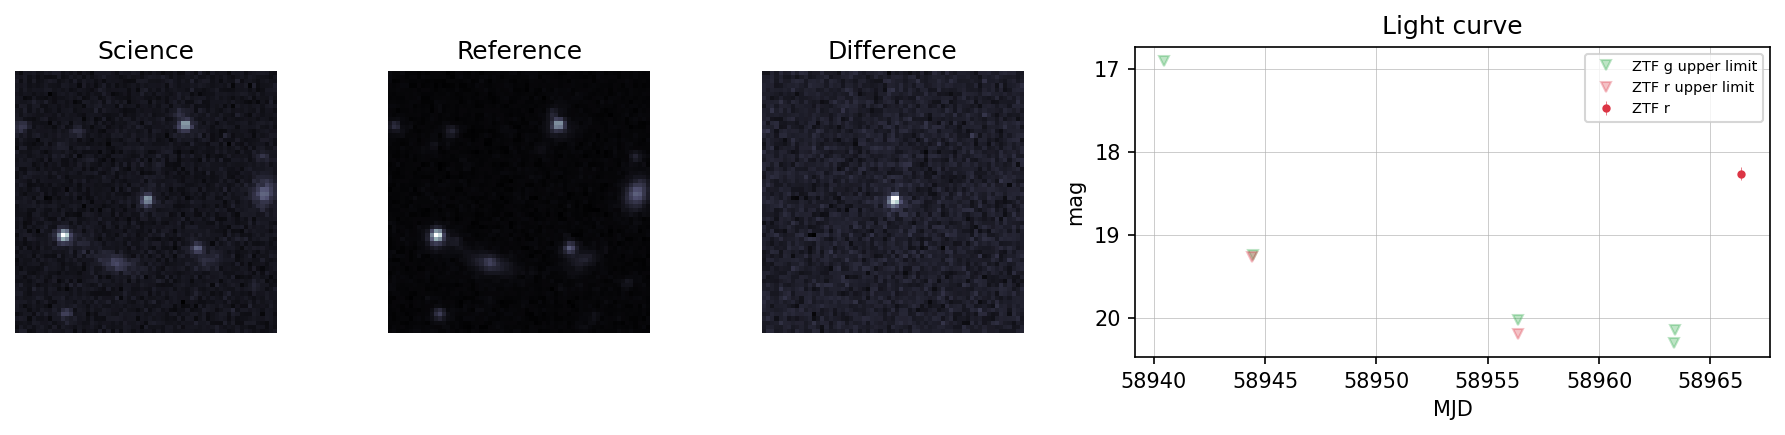

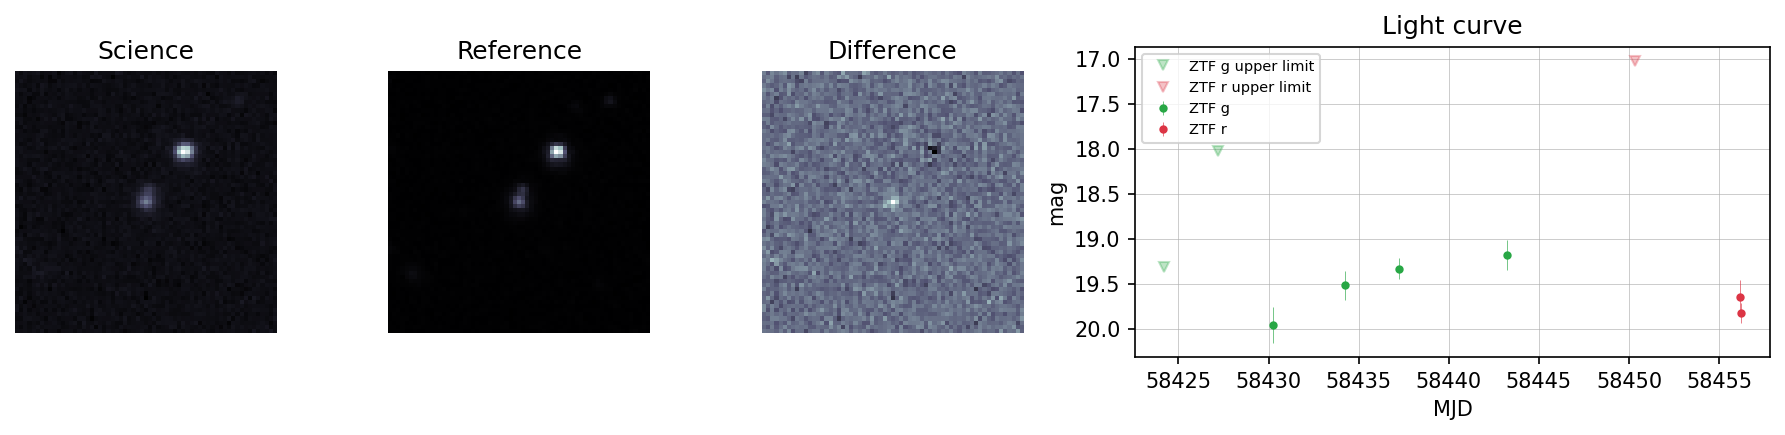

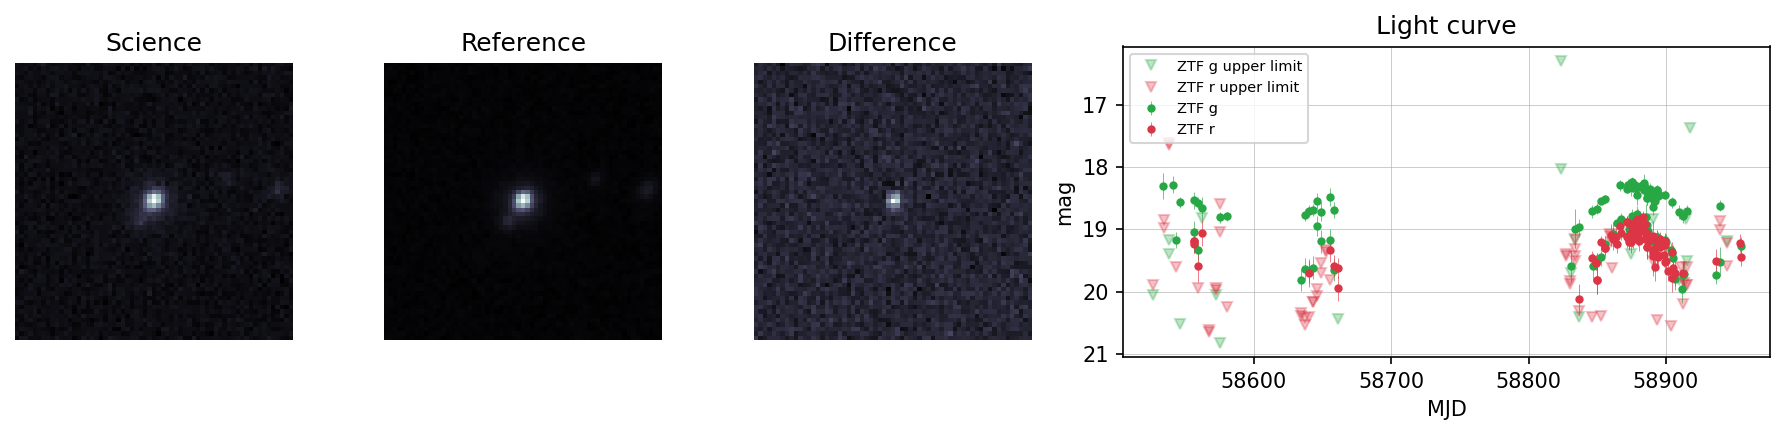

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


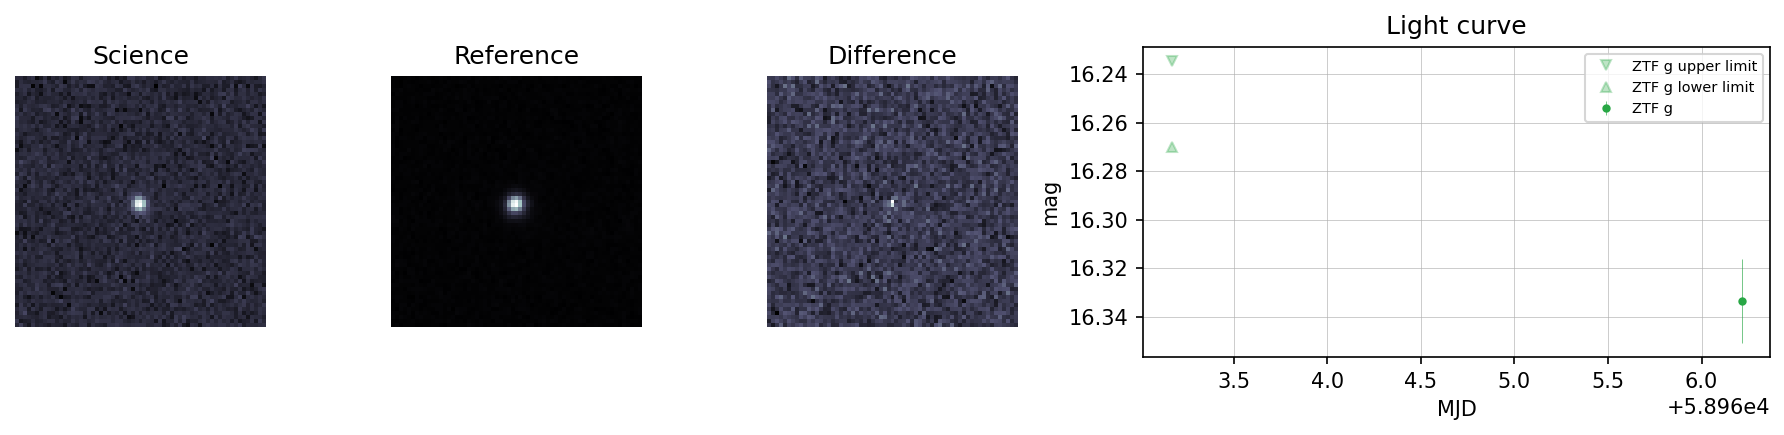

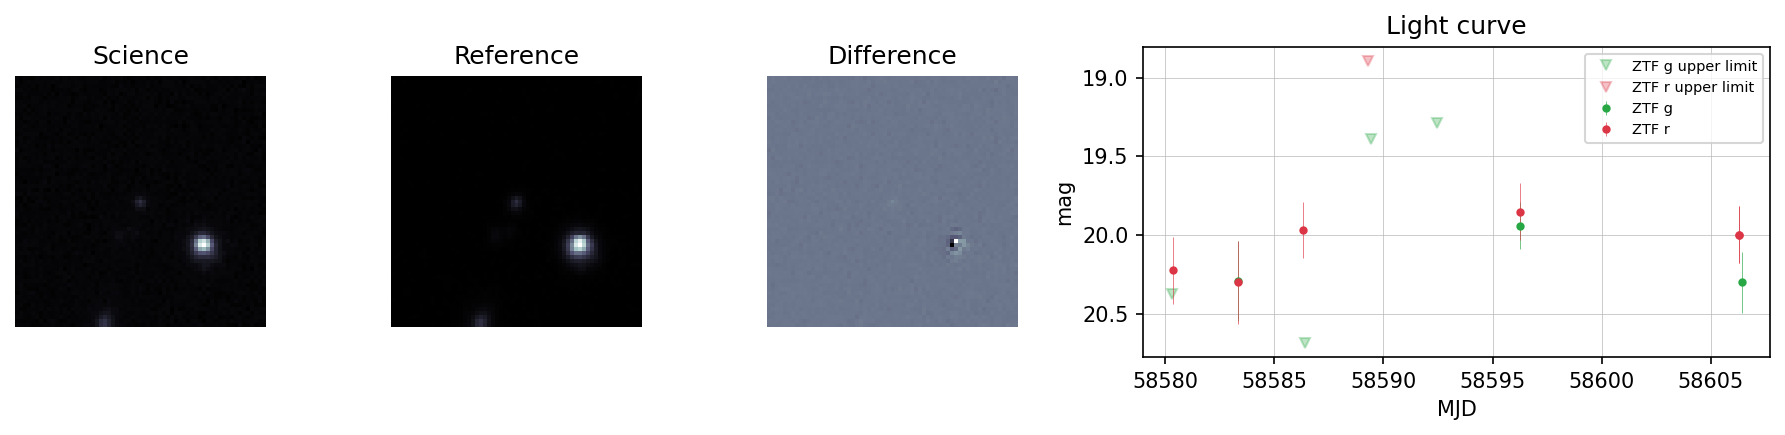

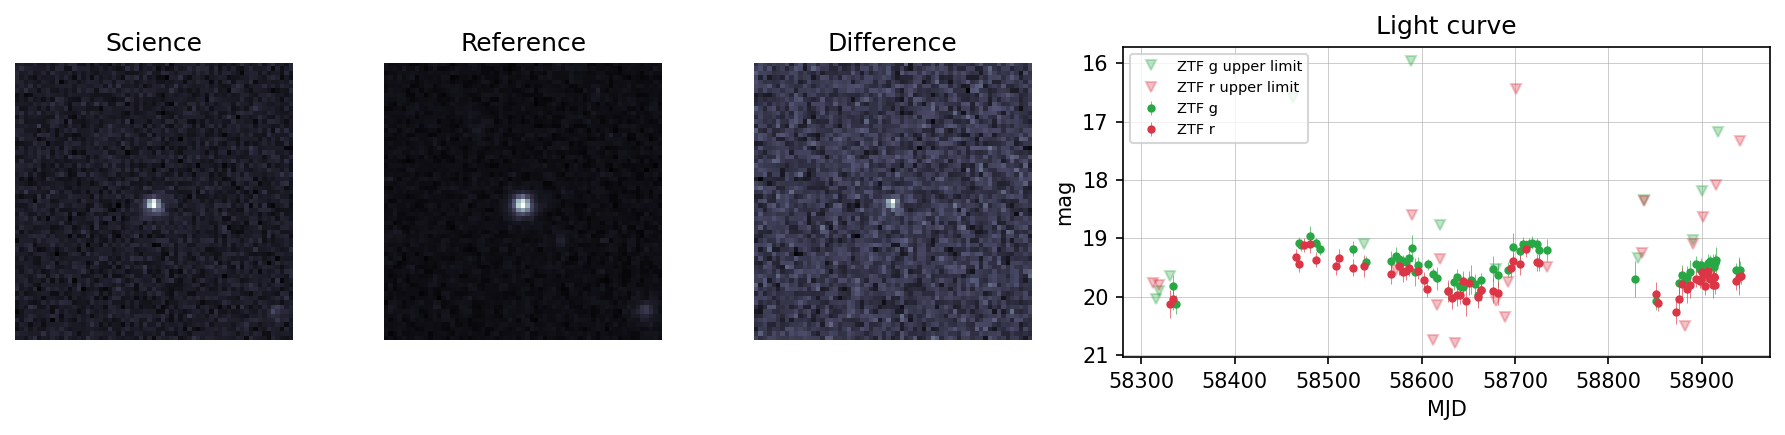

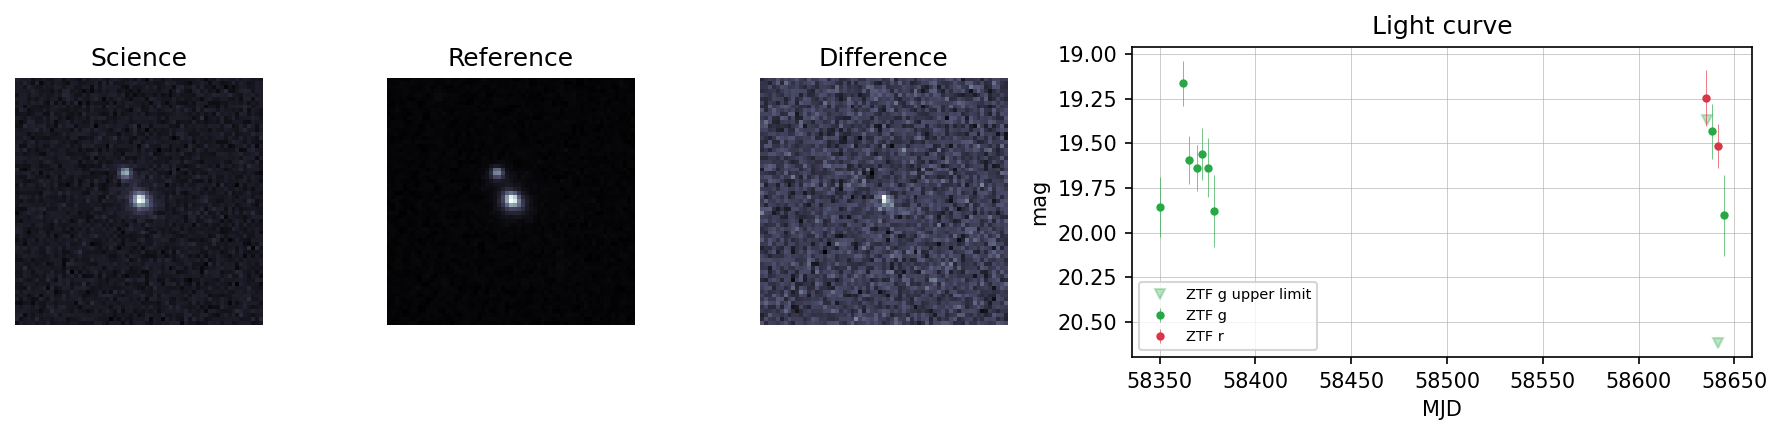

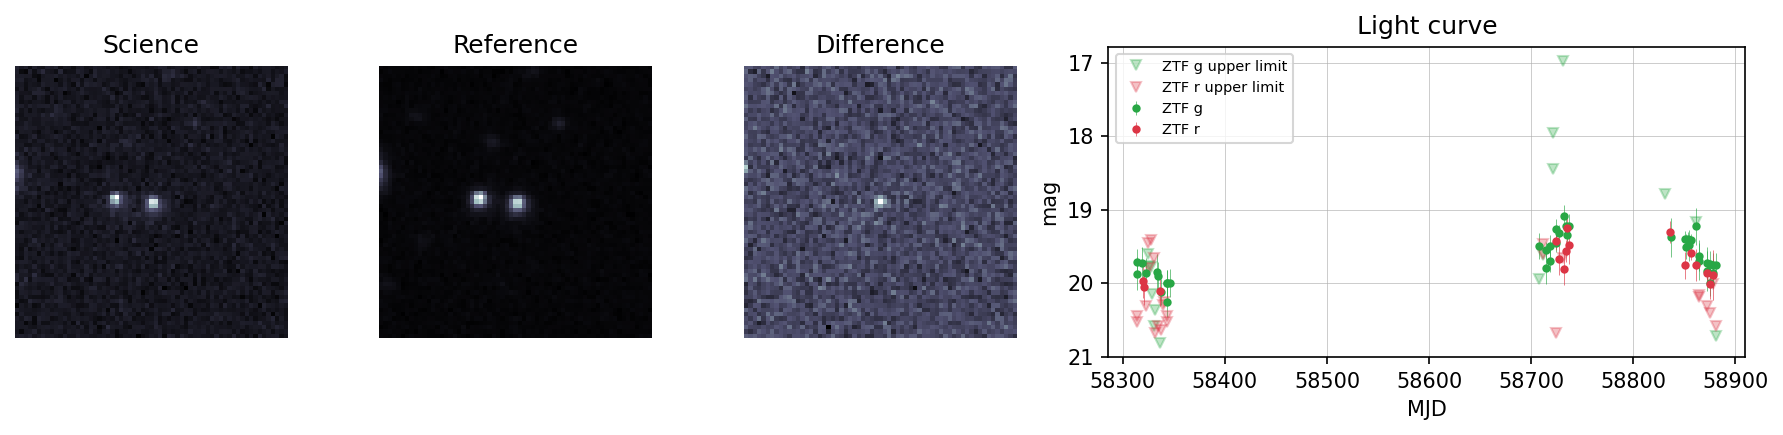

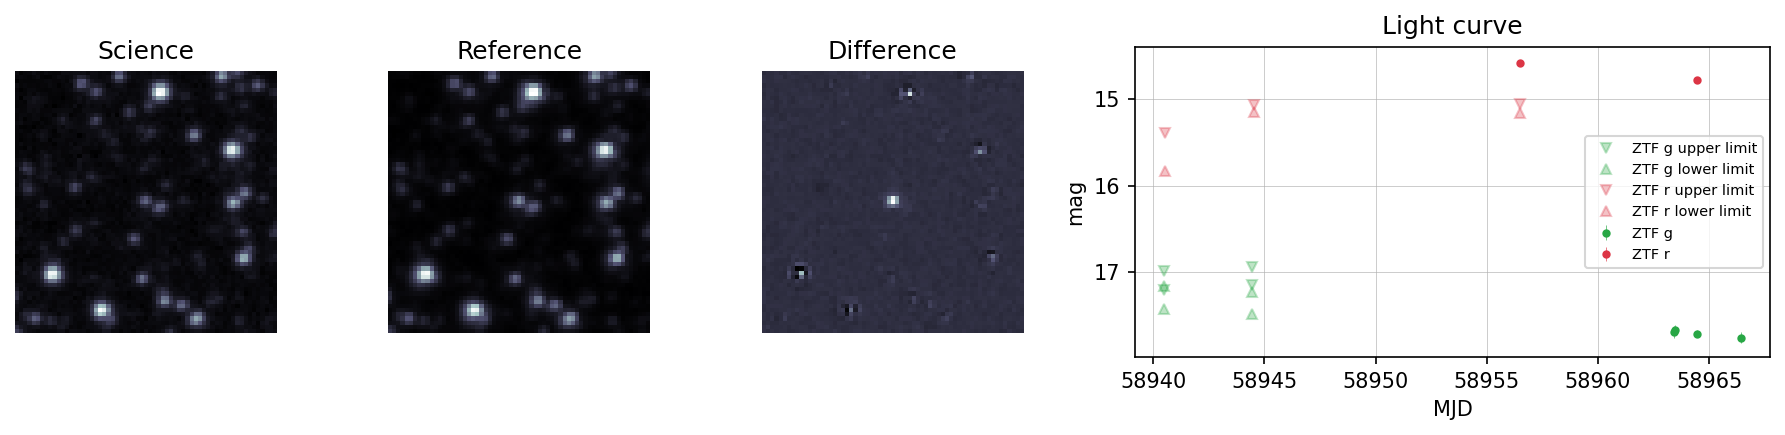

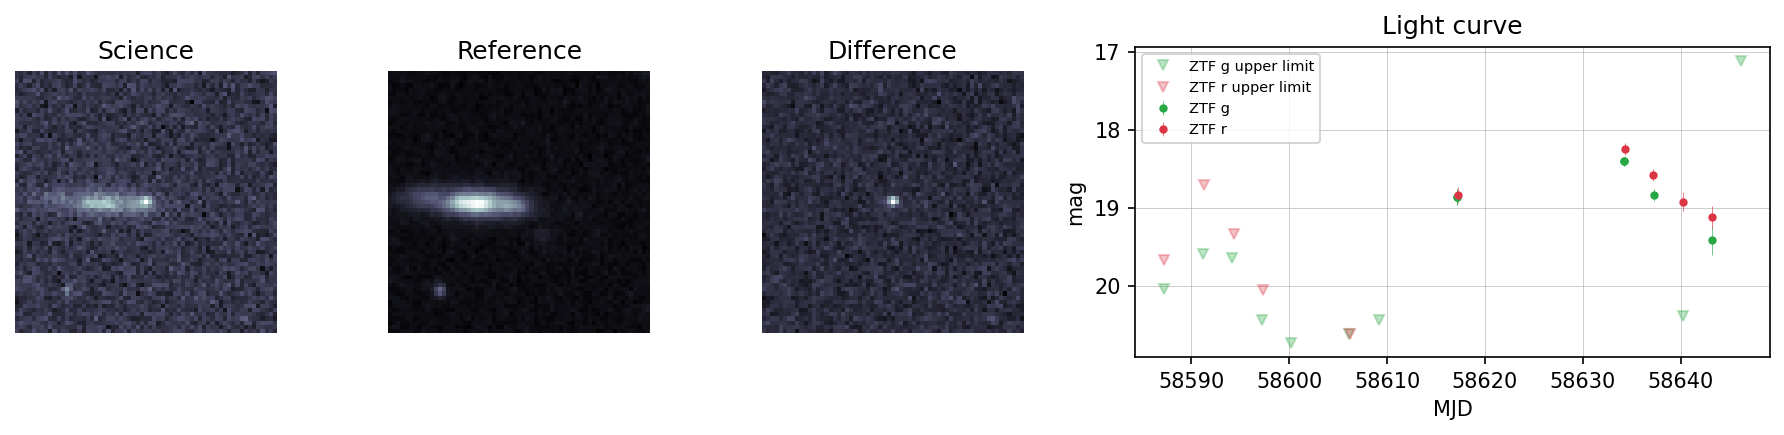

In [25]:
for alert in cursor:
    display_alert_triplet_lc(alert)

### Positional queries

The `coordinates.radec_geojson` field defined for every object in our `ZTF_alerts` collection has an associated spherical 2D index, which allows for efficient positional queries. `MongoDB` supports many query operators, see [here](https://docs.mongodb.com/manual/reference/operator/query-geospatial/) for more details. The caveat to keep in mind is the following: `MongoDB` uses `GeoJSON` objects to represent `2D` positions on the sphere. Both the longitude (`R.A.`) and latitude (`Decl.`) must be expressed in decimal degrees, and the valid longitude values are between `-180` and `180`, both inclusive, so you must subtract 180.0 degrees from your `R.A.` value.

Let's define a helper function for cone searches:

In [26]:
def cone_search(_db, collection='ZTF_alerts',
                ra=0.0, dec=0.0, radius=1.0, unit='arcsec',
                projection=None):
    # cone search radius:
    cone_search_radius = float(radius)
    # convert to rad:
    if unit == 'arcsec':
        cone_search_radius *= np.pi / 180.0 / 3600.
    elif unit == 'arcmin':
        cone_search_radius *= np.pi / 180.0 / 60.
    elif unit == 'deg':
        cone_search_radius *= np.pi / 180.0
    elif unit == 'rad':
        cone_search_radius *= 1
    else:
        raise Exception('Unknown cone search unit. Must be in [deg, rad, arcsec, arcmin]')
    
    # fields to return: everything by default
    if projection is None:
        projection = dict()
    
    cursor = _db[collection].find({}, projection)
    
    cursor = db['ZTF_alerts'].aggregate([
        {
            "$match": {
                'coordinates.radec_geojson': {
                    '$geoWithin': {
                        '$centerSphere': [[ra - 180.0, dec], cone_search_radius]
                    }
                }
            }
        },
        {
            "$lookup": {
                "from": "ZTF_alerts_aux",
                "localField": "objectId",
                "foreignField": "_id",
                "as": "aux"
            }
        },
        {
            "$replaceRoot": {
                "newRoot": {
                    "$mergeObjects": [
                        {
                            "$arrayElemAt": [
                                "$aux",
                                0
                            ]
                        },
                        "$$ROOT"
                    ]
                }
            }
        }
    ])
    
    return cursor

Now let us look for some transients in <a href="https://en.wikipedia.org/wiki/Messier_100" target="_blank">Messier 100</a>:

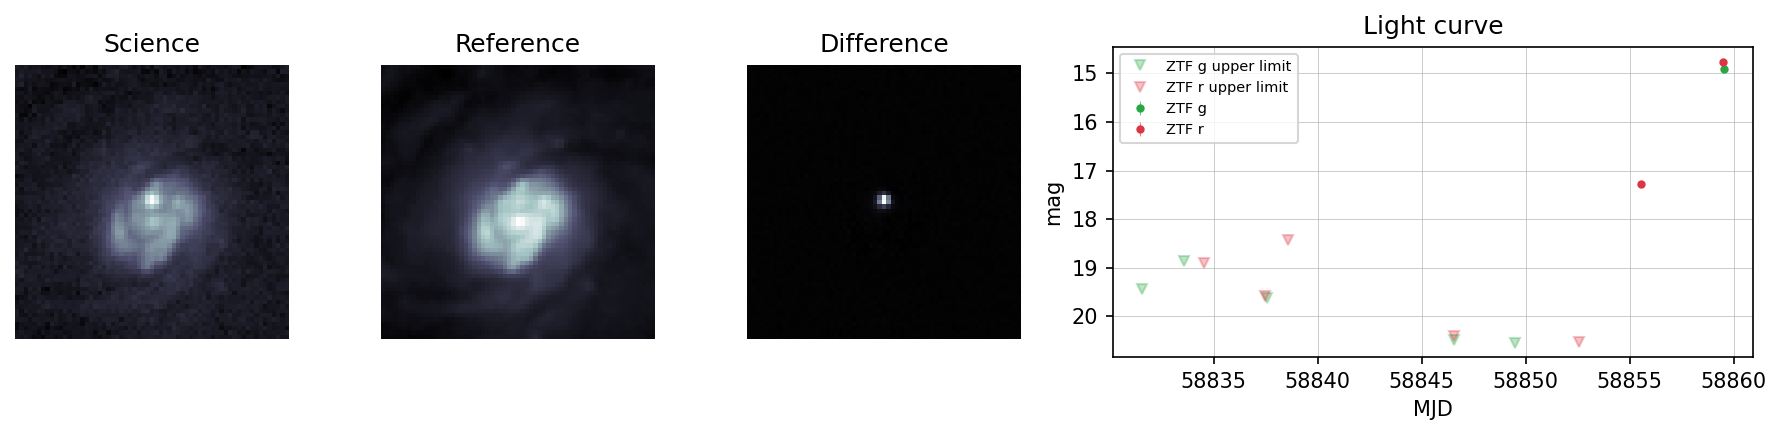

In [27]:
alerts = list(
    cone_search(db, ra=185.7287500, dec=15.8225000, radius=30.0, unit='arcsec', projection={'_id': 0})
)

for alert in alerts:
    display_alert_triplet_lc(alert)

## Further studying

<a href="https://www.coursera.org/learn/introduction-mongodb" target="_blank">Introduction to MongoDB official class <i class="fa fa-external-link" aria-hidden="true"></i></a>

<a href="https://www.datacamp.com/community/tutorials/introduction-mongodb-python" target="_blank">Introduction to MongoDB and Python <i class="fa fa-external-link" aria-hidden="true"></i></a>

<a href="https://docs.mongodb.com/manual/reference/sql-aggregation-comparison/" target="_blank">SQL to MongoDB Aggregation Mapping Chart <i class="fa fa-external-link" aria-hidden="true"></i></a>